In [1]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from progressbar import * #进度条
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure

os.environ['CUDA_VISIBLE_DEVICES']='1'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
label2int = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
int2lable = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [3]:
#由于数据集较大，采用tensorflow自带的TFRecord进行读取
def Trainset2TFRecord2(train_tfrecords_path, val_tfrecords_path, ratio=0.9, data_path='data'):
    files = natsorted(glob.glob(data_path + '/train/*'))
    total = len(files)
    train_num = int(total*ratio)
    val_num = total-train_num
    if (os.path.exists(train_tfrecords_path) and os.path.exists(val_tfrecords_path)):
        print('data have already processed')
        return train_num, val_num
    
    writer_train = tf.python_io.TFRecordWriter(train_tfrecords_path)
    writer_val = tf.python_io.TFRecordWriter(val_tfrecords_path)
    
    labels = pd.read_csv(data_path + '/trainLabels.csv')
    
    pbar = ProgressBar().start()
    for i, file_path in enumerate(files):
        pbar.update(int((i / (total - 1)) * 100))#进度条
        time.sleep(0.01)

        img_raw = tf.gfile.FastGFile(file_path, 'rb').read()
        label = label2int[labels.loc[i].label]

        example = tf.train.Example(features=tf.train.Features(feature={
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }))
        if i < train_num:
            writer_train.write(example.SerializeToString())
        else:
            writer_val.write(example.SerializeToString())
    writer_train.close()
    writer_val.close()
    pbar.finish()
    
    return train_num, val_num
def TFRecord2TrainData2(train_tfrecords_path, num_class, batch_size, num_epochs, shuffle=True):
    filename_queue = tf.train.string_input_producer([train_tfrecords_path], num_epochs=num_epochs)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                   features={
                                       'img_raw' : tf.FixedLenFeature([], tf.string),
                                       'label': tf.FixedLenFeature([], tf.int64)
                                   })
    img = tf.image.decode_png(features['img_raw'])  # 与方式一的不同点在于需要用decode_png/decode_jpeg解码
                                                    # output an RGB image. [height, width, channels]
    img = tf.reshape(img, [32, 32, 3])
    img = tf.image.resize_images(img, [224, 224])
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label,num_class,1,0)
    if shuffle==True:
        img_batch, label_batch = tf.train.shuffle_batch([img, label], batch_size=batch_size,\
                                                        capacity=500 + 3 * batch_size, min_after_dequeue=500)
    else:
        img_batch, label_batch = tf.train.batch([img, label], batch_size=batch_size, capacity= 3 * batch_size)
    return img_batch, label_batch

In [4]:
train_tfrecords_path = 'data/train.tfrecord'
val_tfrecords_path = 'data/val.tfrecord'
train_num, val_num = Trainset2TFRecord2(train_tfrecords_path, val_tfrecords_path)
print(train_num, val_num)

data have already processed
45000 5000


In [4]:
#解码并查看效果
#img,label = TFRecord2TrainData(train_tfrecords_path, 10)
#img_batch, label_batch = tf.train.shuffle_batch([img, label], batch_size=500, capacity=50000, min_after_dequeue=1000, num_threads=1)
#capacity是队列的最大容量, min_after_dequeue是dequeue后最小的队列大小,这个代表队列中的元素大于它的时候就输出乱的顺序的batch
#num_threads是进行队列操作的线程数。
img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, 10, 128, 5)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, 10, 128, 5)#10类 batch_size=128, epoch = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    #先产生！个看下效果
    '''
    for epoch in range(10):
        try:
            while not coord.should_stop():
                img_, label_ = sess.run([img_batch, label_batch]) 
                print(epoch)
        except tf.errors.OutOfRangeError:
            print("done")
        finally:
            coord.request_stop()
        coord.join(threads)
    ''' 
    #验证集上测试
    try:
        train_total_batch = int(train_num/128)
        val_total_bath = int(val_num/128)
        epoch = 0
        while not coord.should_stop():#使用 coord.should_stop()来查询是否应该终止所有线程
            #开始一个epoch的训练
            train_begin = 0
            val_begin = 0
            for i in range(train_total_batch):
                img_, label_ = sess.run([img_train_batch, label_train_batch]) 
                if train_begin == 0:
                    print("train")
                    print(epoch, img_.shape)
                    train_begin = 1
            for i in range(val_total_bath):
                img_, label_ = sess.run([img_val_batch, label_val_batch]) 
                if val_begin == 0:
                    print("val")
                    print(epoch, img_.shape)
                    val_begin = 1
            epoch+=1
    except tf.errors.OutOfRangeError:
        print("done")
    finally:       
        coord.request_stop()#使用coord.request_stop()来发出终止所有线程的命令
        coord.join(threads)#使用coord.join(threads)把线程加入主线程，等待threads结束。
    '''
    for i in range(10): #产生10个batch
        img_, label_ = sess.run([img_batch, label_batch])#每次输出queue中的一个batch
        plt.subplot(2, 5, i+1)
        label = int2lable[np.argmax(label_, axis=1)[0]]
        plt.title(label)
        plt.imshow(img_[0].astype('uint8'))
        i += 1
    plt.show()
    coord.request_stop()
    coord.join(threads)
    '''

train
0 (128, 224, 224, 3)
val
0 (128, 224, 224, 3)
train
1 (128, 224, 224, 3)
val
1 (128, 224, 224, 3)
train
2 (128, 224, 224, 3)
val
2 (128, 224, 224, 3)
train
3 (128, 224, 224, 3)
val
3 (128, 224, 224, 3)
train
4 (128, 224, 224, 3)
val
4 (128, 224, 224, 3)
train
5 (128, 224, 224, 3)
done


In [5]:
def batch_augment(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        #iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

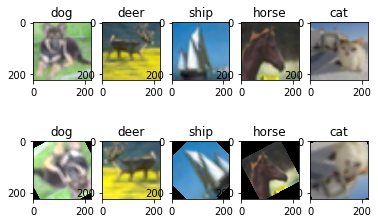

In [6]:
batch_size = 5
img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, 10, batch_size, 1)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, 10, batch_size, 1)#10类 batch_size=128, epoch = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(1) : #产生1个batch
        img_batch, label_batch = sess.run([img_train_batch, label_train_batch])#每次输出queue中的一个batch
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_batch[j].astype('uint8'))
        #扩增后的数据
        '''
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+batch_size+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_batch[j].astype('uint8'))
        '''
        img_aug = batch_augment(img_batch)
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+batch_size+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_aug[j].astype('uint8'))
        
    plt.show()
    coord.request_stop()
    coord.join(threads)

In [ ]:
class ResetNet50:
    def idenitity_block(self, X_input, kernel_size, in_filter, out_filter, stage, block, training):
        block_name = 'res'+str(stage)+block
        f1, f2, f3 = out_filter
        with tf.variable_scope(block_name):
            X_shortcut = X_input
            #first
            conv1 = tf.layers.conv2d(X_input, f1, 1, strides=1, padding='same')
            bn1 = tf.layers.batch_normalization(conv1, axis=3, training=training)
            #其中 axis 参数表示沿着哪个轴进行正则化，一般而言Tensor是[batch, width_x, width_y, channel]，
            #如果是[width_x, width_y, channel，batch]则axis应该设为3
            relu1 = tf.nn.relu(bn1)
            #second
            conv2 = tf.layers.conv2d(relu1, f2, kernel_size, strides=1, padding='same')
            bn2 = tf.layers.batch_normalization(conv2, axis=3, training=training)
            relu2 = tf.nn.relu(bn2)
            #third
            conv3 = tf.layers.conv2d(relu2, f3, 1, strides=1, padding='same')
            bn3 = tf.layers.batch_normalization(conv3, axis=3, training=training)
            #final step
            add = tf.add(bn3, X_shortcut)
            add_result = tf.nn.relu(add)
        return add_result
    def convolutional_block(self, X_input, kernel_size, in_filter, out_filter, stage, block, training, strides=2):
        block_name = 'res' + str(stage) + block
        with tf.variable_scope(block_name):
            f1, f2, f3 = out_filter
            x_shortcut = X_input
            #first
            conv1 = tf.layers.conv2d(X_input, f1, 1, strides=strides, padding='valid')
            bn1 = tf.layers.batch_normalization(conv1, axis=3, training=training)
            relu1 = tf.nn.relu(bn1)
            #second
            conv2 = tf.layers.conv2d(relu1, f2, kernel_size, strides=1, padding='same')
            bn2 = tf.layers.batch_normalization(conv2, axis=3, training=training)
            relu2 = tf.nn.relu(bn2)
            #thirs
            conv3 = tf.layers.conv2d(relu2, f3, 1, strides=1, padding='valid')
            bn3 = tf.layers.batch_normalization(conv3, axis-3, training=training)
            #shortcut path
            x_shortcut = tf.layers.conv2d(x_shortcut, f3, 1, strides=strides, padding='valid')
            #final
            add = tf.add(bn3, x_shortcut)
            add_result = tf.nn.relu(add)
        return add_result
    def deepnn(self, X_input, classnum):
        x = tf.pad(X_input, tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]]), 'CONSTANT')
        with tf.variable_scope('refernce'):
            training = tf.placeholder(tf.bool, name='training')
            #stage 1
            conv1 = tf.layers.conv2(x, 64, 7, strides=2, padding='valid')
            bn1 = tf.layers.batch_normalization(conv1, axis=3, training=training)
            relu1 = tf.nn.relu(bn1)
            pool1 = tf.layers.max_pooling2d(relu1, pool_size=[3, 3], strides=2, padding='valid')
            
            assert(pool1.get_shape() == (pool1.get_shape()[0], 15, 15, 64))
            
            #stage 2
            conv_block2 = self.convolutional_block(pool1, 3, 64, [64, 64, 256], 2, 'a', training, strides=1)
            id_block2_1 = self.identity_block(conv_block2, 3, 256, [64, 64, 256], stage=2, 'b', training=training)
            id_block2_2 = self.identity_block(id_block2_1, 3, 256, [64, 64, 256], stage=2, block='c', training=training)
            #stage 3
            conv_block3 = self.convolutional_block(id_block2_2, 3, 256, [128,128,512], 3, 'a', training)
            id_block3_1 = self.identity_block(conv_block3, 3, 512, [128,128,512], 3, 'b', training=training)
            id_block3_2 = self.identity_block(id_block3_1, 3, 512, [128,128,512], 3, 'c', training=training)
            id_block3_3 = self.identity_block(id_block3_2, 3, 512, [128,128,512], 3, 'd', training=training)     
            #stage 4
            conv_block4 = self.convolutional_block(id_block3_3, 3, 512, [256, 256, 1024], 4, 'a', training)
            id_block4_1 = self.identity_block(conv_block4, 3, 1024, [256, 256, 1024], 4, 'b', training=training)
            id_block4_2 = self.identity_block(id_block4_1, 3, 1024, [256, 256, 1024], 4, 'c', training=training)
            id_block4_3 = self.identity_block(id_block4_2, 3, 1024, [256, 256, 1024], 4, 'd', training=training)
            id_block4_4 = self.identity_block (id_block4_3, 3, 1024, [256, 256, 1024], 4, 'e', training=training)
            id_block4_5 = self.identity_block(id_block4_4, 3, 1024, [256, 256, 1024], 4, 'f', training=training)  
            #stage 5
            conv_block5 = self.convolutional_block(id_block4_5, 3, 1024, [512, 512, 2048], 5, 'a', training)
            id_block5_1 = self.identity_block(conv_block5, 3, 2048, [512, 512, 2048], 5, 'b', training=training)
            id_block5_2 = self.identity_block(id_block5_1, 3, 2048, [512, 512, 2048], 5, 'c', training=training)     
            
            pool = tf.layers.average_pooling2d(id_block5_2, pool_size=[2, 2], strides=1, padding='valid')
            flatten = tf.layers.flatten(pool)
            fc1 = tf.layers.dense(flatten, 50, activation=tf.nn.relu)
            with tf.name_scope('dropout'):
                if training = True:
                    fc1 = tf.layers.dropout(fc1, 0.5)
                else:
                    fc1 = fc1
            logits = tf.layers.dense(fc1, classnum)
            return logits, training